# Metric table paper figures

## Paths and imports

In [1]:
DATA_DIR = "/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/data/"
RESULTS_DIR = "/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
from matplotlib import colors
from matplotlib import patches

plt.rcParams['figure.dpi'] = 150
SMALL_SIZE =   9  #17
MEDIUM_SIZE = 11  #19
BIGGER_SIZE = 13  #21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## plot functions

In [12]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
import seaborn as sns



def format_time(time):
    """
    time: float
        in seconds.

    Return
    ------
    str
        formatted time
    """
    days = int(time // (3600 * 24))
    hours = int(time // 3600)
    mins = int(time // 60)
    secs = int(time // 1)
    unit = ["d", "h", "min", "sec"]
    for t, u in zip([days, hours, mins, secs], unit):
        if t > 0:
            return f"{t} {u}"
    return "0 sec"


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def summary_table(
    table,
    summaries="all",
    color_maps={},
    rename_cols={},
    rename_rows={},
    time_format=[],
    log_scale=[],
    color_limits={},
    nan_color='lightgrey',
    threshold_ann={},
    groups=[],
    xticklabel_rotation=0,
    xticklabel_multialignment='right',
    max_val_bold=True,
    show=True,
    save=False,
):
    """Plot table of summary statistics

    table: pd.DataFrame

    summaries: "all" or list of strs
        List of summary metrics that are plotted.
    color_maps: dict
        Color maps assigned to summary metrics. Use the initial name and not the potential new name
        given via `rename_cols`.
    rename_cols: dict
        Rename summary metrics for plot.
    rename_rows: dict
        Rename set ids.
    time_format: list of strs
        Summary names that are formatted to days, hours, mins and secs (seconds are expected as input).
    log_scale: list of strs
        Summary names for which a log scaled colormap is applied.
    color_limits: dict of lists of two floats
        For each summary metric optionally provide vmin and vmax for the colormap.
    nan_color: str
        Color for nan values.
    threshold_ann: dict
        Special annotation for values above defined threshold. E.g. {"time":{"th":1000,"above":True,"ann":"> 1k"}}
    groups: List[List[str,[int,int]]]
        For group brackets
    max_val_bold: bool
        Wheter to show the max (min for time formats) value in each column with bold formatting
    xticklabel_multialignment: str
        How to align multi line x tick labels. (one of 'center', 'right', 'left')

    """

    fsize = 15
    figsize_factor = 0.85

    # Default order and colors
    default_order = ["score","cluster_similarity", "knn_overlap", "Greens", "forest_clfs", "marker_corr", "gene_corr",
                     "penalty"]
    default_cmaps = {
        "cluster_similarity": "Greens",
        "knn_overlap": "Greens",
        "forest_clfs": "Purples",#"Reds",
        "marker_corr": "Purples",#"Reds",
        "gene_corr": "Blues",
        "penalty": truncate_colormap(plt.get_cmap('Greys'), minval=0.05, maxval=0.7, n=100), #"Greys",
        "other": "Greys",
    }

    if summaries == "all":
        summaries = table.columns.tolist()
        for s in summaries:
            if s not in default_order:
                default_order.append(s.split()[0])
        # Order by default order of metrics and length of summary
        summaries.sort(key=lambda s: default_order.index(s.split()[0]) * 100 + len(s))

    cmaps = {}
    for summary in summaries:
        if summary in color_maps:
            cmaps[summary] = color_maps[summary]
        elif summary.split()[0] in default_cmaps:
            cmaps[summary] = default_cmaps[summary.split()[0]]
        else:
            cmaps[summary] = default_cmaps["other"]

    # Init final table for plotting
    df = table[summaries].copy()

    # Register potential new names of columns that are time formatted or log transformed
    for col in df.columns:
        if (col in time_format) and (col in rename_cols):
            time_format.append(rename_cols[col])
        if (col in log_scale) and (col in rename_cols):
            log_scale.append(rename_cols[col])
        if (col in color_limits) and (col in rename_cols):
            color_limits[rename_cols[col]] = color_limits[col]
        if (col in threshold_ann) and (col in rename_cols):
            threshold_ann[rename_cols[col]] = threshold_ann[col]
        
    # Rename columns
    df = df.rename(columns=rename_cols, index=rename_rows)
    
    # Replace old column names with new names in colormaps
    for summary, new_key in rename_cols.items():
        cmaps[new_key] = cmaps.pop(summary)

    n_cols = len(df.columns)
    n_sets = len(df.index)

    draw_group_brackets = True if groups else False
    
    fig = plt.figure(figsize=(figsize_factor*n_cols * 1.05, figsize_factor*(n_sets+int(draw_group_brackets))))
    if draw_group_brackets:
        gs1 = gridspec.GridSpec(n_sets+int(draw_group_brackets),n_cols)
    else:
        gs1 = gridspec.GridSpec(1, n_cols)
    gs1.update(wspace=0.0, hspace=0.0)

    multi_col = {}
    cols = df.columns.tolist()
    for col in df.columns.unique():
        count = cols.count(col)
        if count > 1:
            multi_col[col] = 0
        
    for group in groups:
        n_cols_group = group[1][1] - group[1][0] + 1
        ax = plt.subplot(gs1[0,group[1][0]:group[1][1]+1])
        ax.axis('off')
        ax.set_xlim([0,n_cols_group])
        ax.set_ylim([0,1])
        #if n_cols_group > 1:
        #    x1 , x2 = [0.5 , n_cols_group-0.5]
        #else:
        #    x1 , x2 = [0.3 , n_cols_group-0.3]
        x1 , x2 = [0.2 , n_cols_group-0.2]
        y , h = [0,0.12]#[0,0.3]
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2.5, c="black")
        plt.text((x1+x2)*.5, y+h, group[0], ha='center', va='bottom', color="black", fontsize=fsize)
        
    
    for i, col in enumerate(df.columns):

        
        ax = plt.subplot(gs1[1:,i]) if draw_group_brackets else plt.subplot(gs1[i])

        yticklabels = bool(i == 0)

        if col in multi_col: # TODO: time formating multi col support? Better get col pos at the beginning + iloc
            col_pos = [i for i, c in enumerate(df.columns) if c == col][multi_col[col]]
            color_vals = np.log(df.iloc[:,[col_pos]]) if (col in log_scale) else df.iloc[:,[col_pos]]
            multi_col[col] += 1
        else:
            color_vals = np.log(df[[col]]) if (col in log_scale) else df[[col]]
            col_pos = [i for i, c in enumerate(df.columns) if c == col][0]
            
        if col in time_format:
            #annot = df[col].apply(format_time).values[:, np.newaxis]
            annot = df.iloc[:,col_pos].apply(format_time).values[:, np.newaxis]
            fmt = ""
        else:
            annot = True
            fmt = ".2f"
        if col in threshold_ann:
            formatter = lambda s: f"{s:.2f}"
            annot = df.iloc[:,col_pos].apply(formatter).values[:, np.newaxis] if isinstance(annot,bool) else annot
            tmp = threshold_ann[col]            
            th_mask = (df.iloc[:,col_pos] > tmp["th"]) if tmp["above"] else (df.iloc[:,col_pos] < tmp["th"])
            annot[th_mask,:] = tmp["ann"]
            fmt=""

        g = sns.heatmap(
            color_vals,
            cmap=cmaps[col],
            annot=annot,
            mask=color_vals.isnull(),
            cbar=False,
            square=True,#(not draw_group_brackets),
            yticklabels=yticklabels,
            fmt=fmt,
            annot_kws={"fontsize": fsize - 2},
            vmin=color_limits[col][0] if (col in color_limits) else None,
            vmax=color_limits[col][1] if (col in color_limits) else None,
        )
        g.set_facecolor(nan_color)
        plt.tick_params(
            axis="x", which="major", labelsize=fsize, labelbottom=True, bottom=True, 
            top=False, labeltop=False
        )
        plt.tick_params(axis="y", which="major", labelsize=fsize)
        ax.set_xticklabels(ax.get_xticklabels(), horizontalalignment="center", rotation=xticklabel_rotation, multialignment=xticklabel_multialignment)#'right')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        if max_val_bold:
            if col in time_format:
                extremum = format_time(df.iloc[:,col_pos].min())
            else:
                extremum = f"{np.max(color_vals[col].values):.2f}"
            for text in g.texts:
                if text.get_text() == extremum:
                    text.set_weight('bold')            
    
    if show:
        plt.show()
    if save:
        fig.savefig(save, bbox_inches="tight")
    plt.close()

### Fig 1d

In [5]:
table = pd.read_csv(RESULTS_DIR+"FSmethods_evaluation/Madissoon_summary.csv",index_col=0)
selection_info = pd.read_csv(RESULTS_DIR+"FSmethods_selection/selections_info.csv",index_col=0)

In [6]:
# Add penalty terms to table
#selections = pd.read_csv("./scripts/results/FSmethods_selection/selections.csv",index_col=0)
selections = pd.read_csv(RESULTS_DIR+"FSmethods_selection/selections.csv",index_col=0)
adata = sc.read(DATA_DIR+'processed/Madissoon2019.h5ad')

table["penalty high_expression"] = 0
table["penalty low_expression"] = 0

for col in selections.columns:
    genes = selections.loc[selections[col]].index.tolist()
    table.loc[col,"penalty high_expression"] = adata.var.loc[genes,'expression_penalty_upper'].mean(axis=0)
    table.loc[col,"penalty low_expression"] = adata.var.loc[genes,'expression_penalty_lower'].mean(axis=0)

In [7]:
names_based_on_options = {
    "pca (unscaled)" : {"method":"pca", "scaled":False},
    "pca (scaled)" : {"method":"pca", "scaled":True},
    "hvg" : {"method":"hvg"},
    "spca (unscaled)" : {"method":"spca", "scaled":False},
    "spca (scaled)" : {"method":"spca", "scaled":True},    
    "highest expr." : {"method":"highest_expr"},
    "diff. expr." : {"method":"DE"},
    "random" : {"method":"random"},
}

# Select 
filters = [
    ((selection_info["method"] == "pca") & ~selection_info["scaled"]),
    ((selection_info["method"] == "pca") & selection_info["scaled"])
]
sort_by = ['cluster_similarity nmi_7_23', 'cluster_similarity nmi_24_60','knn_overlap mean_overlap_AUC', 'forest_clfs accuracy',
          'forest_clfs perct acc > 0.8']
for f in filters:
    tmp = selection_info.loc[f].index.tolist()
    filter_out = [s for s in table.loc[tmp].index if (s != table.loc[tmp,sort_by].sum(axis=1).idxmax())]
    # subset table
    table = table.loc[~table.index.isin(filter_out)]


# Add run time to table
table["time_seconds"] = selection_info["time_seconds"]

# Get set_ids for each method name/configuration
name_to_selections = {}
for name, options in names_based_on_options.items():
    filt = True
    for o, val in options.items():
        filt = filt & (selection_info[o] == val)
    name_to_selections[name] = [s for s in selection_info.loc[filt].index.tolist() if s in table.index]
    
# Convert set_ids to names and take mean if method occured multiple times (applies for method "random" only here)
table_renamed = pd.DataFrame(columns=table.columns)
for name, selections in name_to_selections.items():
    if len(selections) == 1:
        table_renamed.loc[name] = table.loc[selections[0]]
    else:
        table_renamed.loc[name] = table.loc[selections].mean()
        
## Sort table
#table_renamed["tmp"] = table_renamed[sort_by].sum(axis=1)
#table_renamed = table_renamed.sort_values("tmp",ascending=False)
#del table_renamed["tmp"]

# Aggregate score
aggregate_var_recov = ['cluster_similarity nmi_7_23', 'cluster_similarity nmi_24_60','knn_overlap mean_overlap_AUC'] 
aggregate_ct_clf = ['forest_clfs accuracy', 'forest_clfs perct acc > 0.8']
tmp1 = table_renamed[aggregate_var_recov].mean(axis=1)
tmp2 = table_renamed[aggregate_ct_clf].mean(axis=1)
table_renamed["score"] = pd.concat([tmp1,tmp2],axis=1).mean(axis=1)
table_renamed = table_renamed.sort_values("score",ascending=False)

# Delete metric "marker_corr per marker"
del table_renamed["marker_corr per marker"]

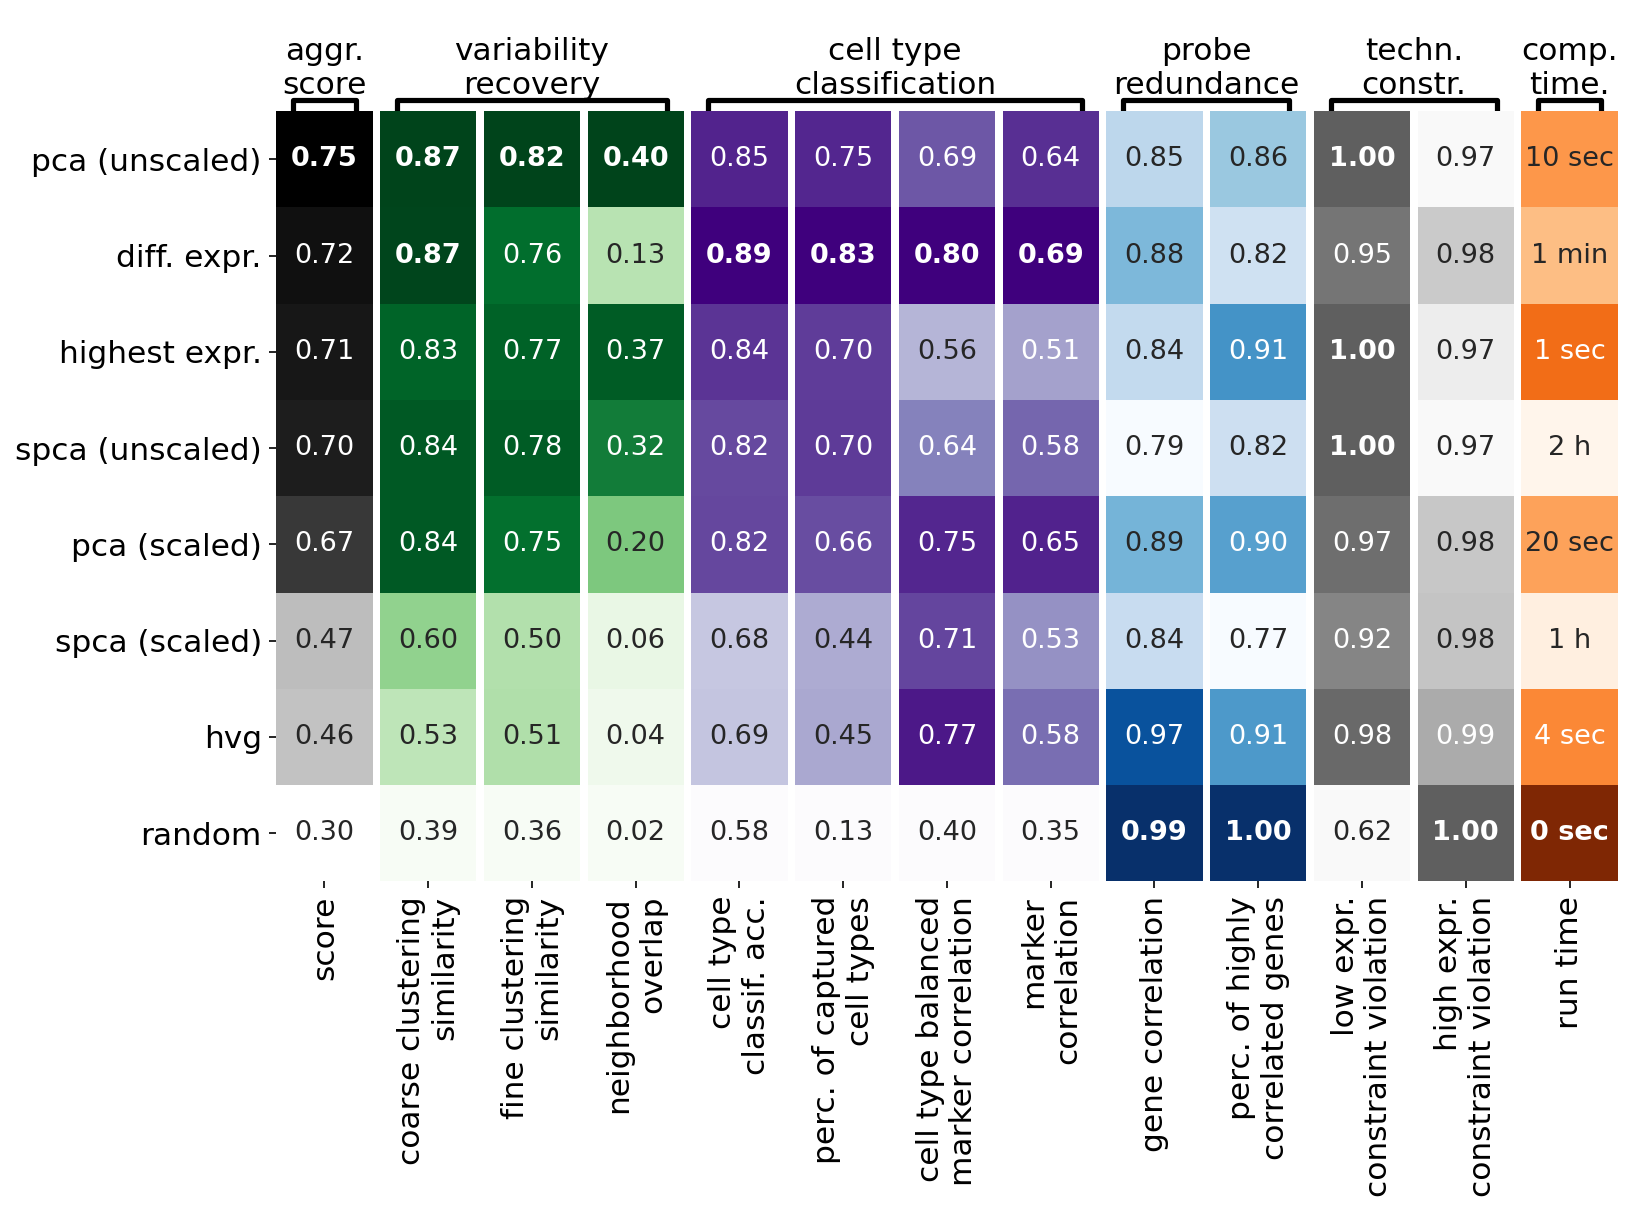

In [13]:
rename_cols = {
    'score'                               : "score",
    'cluster_similarity nmi_7_23'         : "coarse clustering\nsimilarity",
    'cluster_similarity nmi_24_60'        : "fine clustering\nsimilarity",
    'knn_overlap mean_overlap_AUC'        : "neighborhood\noverlap",
    'forest_clfs accuracy'                : "cell type\nclassif. acc.",
    'forest_clfs perct acc > 0.8'         : "perc. of captured\n cell types",
    'gene_corr 1 - mean'                  : "gene correlation", 
    'gene_corr perct max < 0.8'           : "perc. of highly\ncorrelated genes",
    'marker_corr per celltype'            : "cell type balanced\nmarker correlation",
    'marker_corr per marker mean > 0.025' : "marker\ncorrelation",
    "penalty low_expression"              : "low expr.\nconstraint violation",
    "penalty high_expression"             : "high expr.\nconstraint violation",
    'time_seconds'                        : "run time",
}

summary_table(table_renamed, summaries="all", color_maps={"time_seconds":'Oranges_r'}, 
              rename_cols=rename_cols, rename_rows={}, time_format=["time_seconds"], 
              groups=[["aggr.\nscore",[0,0]],["variability\nrecovery",[1,3]],["cell type\nclassification",[4,7]],
                       ["probe\nredundance",[8,9]],["techn.\nconstr.",[10,11]],["comp.\ntime.",[12,12]]
                     ], xticklabel_rotation=90, 
              log_scale=["time_seconds"], show=True, save="./figures/FSeval_n150_v3.png")

## Figure S8

### Fig S8a

In [20]:
def get_data(dataset="Mad",n=50):
    """
    dataset: "Mad" or "Lit"
    n: 50 or 150
    """
    
    #bdir = "./scripts/results/"
    bdir = "/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/"
    bdir_eval = {
        #"FS":"./scripts/results/",
        "FS":"/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/",
        "external":"/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/",
    }
    eval_dirs = {}
    select_dirs = {}
    if dataset == "Mad":
        data_str = "Madissoon"
        if n == 50:
            eval_dirs["FS"] = "FSmethods_evaluation_n50"
            select_dirs["FS"] = "FSmethods_selection_n50"
        elif n == 150:
            eval_dirs["FS"] = "FSmethods_evaluation"
            select_dirs["FS"] = "FSmethods_selection"            
        eval_dirs["external"] = "Fig4_evaluation_Mad"
        select_dirs["external"] = "Fig4_selection_Mad"
    elif dataset == "Lit":    
        data_str = "Litvinukova"
        eval_dirs["FS"] = "FSmethods_evaluation_heart"
        select_dirs["FS"] = "FSmethods_selection_heart"
        eval_dirs["external"] = "Fig4_evaluation_Lit"
        select_dirs["external"] = "Fig4_selection_Lit"        
    
    tables = {}
    selection_infos = {}
    selections_dict = {}

    for key in ["FS","external"]:
        tables[key] = pd.read_csv(bdir_eval[key]+f"{eval_dirs[key]}/{data_str}_summary.csv",index_col=0)
        selection_infos[key] = pd.read_csv(bdir+f"{select_dirs[key]}/selections_info.csv",index_col=0)
        selections_dict[key] = pd.read_csv(bdir+f"{select_dirs[key]}/selections.csv",index_col=0)
    
    return tables, selection_infos, selections_dict

In [21]:
n = 150

tables, selection_infos, selections_dict = get_data(dataset="Lit",n=n)

In [22]:
def get_table(tables, selection_infos, selections_dict,n,print_table=True):
    names_based_on_options = {
        "pca" : {"method":"pca", "scaled":False},
        "diff. expr." : {"method":"DE"},
        "spapros" : {"method":"spapros"},
        "nsforest" : {"method":"nsforest"},
        "scgenefit" : {"method":"scgenefit"},
        "smash" : {"method":"XGB"},
        "scmer" : {"method":"scmer"},
        "asfs" : {"method":"asfs"},
        "triku" : {"method":"triku"},
        "selfE" : {"method":"selfe"},
        "cosg" : {"method":"cosg"},
    }
    sort_by = ['cluster_similarity nmi_7_23', 'cluster_similarity nmi_24_60','knn_overlap mean_overlap_AUC', 'forest_clfs accuracy',
               'forest_clfs perct acc > 0.8']
    
    renamed_tables = {}
    
    for group in ["FS","external"]:
        table = tables[group]
        selection_info = selection_infos[group]
        selections = selections_dict[group]
        
        tmp = selection_info.loc[selection_info["n"] == n].index.tolist()
        selection_info = selection_info.loc[tmp]
        selections = selections[tmp]
        
        # Select 
        try:
            filters = [
                ((selection_info["method"] == "pca") & ~selection_info["scaled"]),
                ((selection_info["method"] == "pca") & selection_info["scaled"])
            ]
        
            for f in filters:
                tmp = selection_info.loc[f].index.tolist()
                filter_out = [s for s in table.loc[tmp].index if (s != table.loc[tmp,sort_by].sum(axis=1).idxmax())]
                # subset table
                table = table.loc[~table.index.isin(filter_out)]
        except:
            pass
        
        # Add run time to table
        table["time_seconds"] = selection_info["time_seconds"]
        
        # Get set_ids for each method name/configuration
        name_to_selections = {}
        for name, options in names_based_on_options.items():
            filt = True
            for o, val in options.items():
                if o in selection_info.columns:
                    filt = filt & (selection_info[o] == val)
            name_to_selections[name] = [s for s in selection_info.loc[filt].index.tolist() if s in table.index]
            
        # Convert set_ids to names and take mean if method occured multiple times (applies for method "random" only here)
        table_renamed = pd.DataFrame(columns=table.columns)
        for name, selections in name_to_selections.items():
            if len(selections) == 1:
                table_renamed.loc[name] = table.loc[selections[0]]
            else:
                table_renamed.loc[name] = table.loc[selections].mean()
                
        # Sort table
        #table_renamed["tmp"] = table_renamed[sort_by].sum(axis=1)
        #table_renamed = table_renamed.sort_values("tmp",ascending=False)
        #del table_renamed["tmp"]
        
        # Aggregate score
        aggregate_var_recov = ['cluster_similarity nmi_7_23', 'cluster_similarity nmi_24_60','knn_overlap mean_overlap_AUC'] 
        aggregate_ct_clf = ['forest_clfs accuracy', 'forest_clfs perct acc > 0.8']
        tmp1 = table_renamed[aggregate_var_recov].mean(axis=1)
        tmp2 = table_renamed[aggregate_ct_clf].mean(axis=1)
        table_renamed["score"] = pd.concat([tmp1,tmp2],axis=1).mean(axis=1)
        
        
        renamed_tables[group] = table_renamed.loc[~table_renamed.isnull().any(axis=1)]
        
    table_renamed = pd.concat([df for _,df in renamed_tables.items()]) 
    
    if print_table:
        display(table_renamed)
    print("CAUTION: check if the averaging over values makes sense")
    # If same method occurs multiple times take mean of values
    table_renamed = table_renamed.groupby(level=0).mean()
    #table_renamed = table_renamed.sort_values("tmp",ascending=False)
    table_renamed = table_renamed.sort_values("score",ascending=False)
    if print_table:
        display(table_renamed)
    
    #del table_renamed["tmp"]
    
    return table_renamed

# Mad, 50

In [23]:
n = 50
dataset = "Mad"

tables, selection_infos, selections_dict = get_data(dataset=dataset,n=n)
table_renamed = get_table(tables, selection_infos, selections_dict,n)

#for method in ["asfs","scmer"]:
#    table_renamed.loc[method] = np.nan
#    table_renamed.loc[method,"time_seconds"] = 172801

,cluster_similarity nmi_7_23,cluster_similarity nmi_24_60,knn_overlap mean_overlap_AUC,forest_clfs accuracy,forest_clfs perct acc > 0.8,gene_corr 1 - mean,gene_corr perct max < 0.8,marker_corr per marker,marker_corr per celltype,marker_corr per marker mean > 0.025,time_seconds,score
pca,0.797366,0.725706,0.211935,0.777422,0.527982,0.829476,0.807420,0.342844,0.461474,0.525511,20.770435,0.615519
diff. expr.,0.800664,0.681753,0.077216,0.855243,0.716194,0.876871,0.741096,0.467090,0.641262,0.596481,126.917042,0.652798
spapros,0.841375,0.724644,0.093977,0.874384,0.808647,0.844545,0.840304,0.446411,0.616319,0.581228,17496.237896,0.697424
spapros,0.848924,0.725720,0.093975,0.874384,0.808647,0.844545,0.840304,0.446411,0.616319,0.581228,5652.048560,0.698861
nsforest,0.779013,0.641840,0.050667,0.858125,0.730757,0.933696,0.864330,0.471432,0.686385,0.570264,2939.486016,0.642474
scgenefit,0.034394,0.151949,0.004218,0.309313,0.031085,0.992556,1.000000,0.169909,0.240715,0.205085,35.254205,0.116860
smash,0.784533,0.642227,0.045498,0.770590,0.466227,0.933180,0.892240,0.456755,0.607451,0.564149,15670.349658,0.554581
scmer,0.789449,0.691857,0.141929,0.765194,0.414965,0.796670,0.734515,0.332990,0.494687,0.504304,5504.594991,0.565579
asfs,0.765028,0.664739,0.092067,0.830119,0.629106,0.858104,0.984091,0.390725,0.515210,0.516098,19857.162230,0.618445
triku,0.035908,0.035911,0.001941,0.127762,0.080000,0.532453,1.000000,0.109459,0.222288,0.051134,176.086996,0.064234


CAUTION: check if the averaging over values makes sense


,cluster_similarity nmi_7_23,cluster_similarity nmi_24_60,knn_overlap mean_overlap_AUC,forest_clfs accuracy,forest_clfs perct acc > 0.8,gene_corr 1 - mean,gene_corr perct max < 0.8,marker_corr per marker,marker_corr per celltype,marker_corr per marker mean > 0.025,time_seconds,score
spapros,0.845149,0.725182,0.093976,0.874384,0.808647,0.844545,0.840304,0.446411,0.616319,0.581228,11574.143228,0.698142
diff. expr.,0.800664,0.681753,0.077216,0.855243,0.716194,0.876871,0.741096,0.467090,0.641262,0.596481,126.917042,0.652798
nsforest,0.779013,0.641840,0.050667,0.858125,0.730757,0.933696,0.864330,0.471432,0.686385,0.570264,2939.486016,0.642474
selfE,0.810176,0.728303,0.222916,0.783855,0.549314,0.828283,0.953256,0.363017,0.477498,0.542119,82846.449953,0.626858
asfs,0.765028,0.664739,0.092067,0.830119,0.629106,0.858104,0.984091,0.390725,0.515210,0.516098,19857.162230,0.618445
pca,0.797366,0.725706,0.211935,0.777422,0.527982,0.829476,0.807420,0.342844,0.461474,0.525511,20.770435,0.615519
scmer,0.789449,0.691857,0.141929,0.765194,0.414965,0.796670,0.734515,0.332990,0.494687,0.504304,5504.594991,0.565579
smash,0.784533,0.642227,0.045498,0.770590,0.466227,0.933180,0.892240,0.456755,0.607451,0.564149,15670.349658,0.554581
cosg,0.342421,0.416649,0.016848,0.630147,0.154619,0.969729,1.000000,0.374327,0.523358,0.434166,1.539822,0.325511
scgenefit,0.034394,0.151949,0.004218,0.309313,0.031085,0.992556,1.000000,0.169909,0.240715,0.205085,35.254205,0.116860


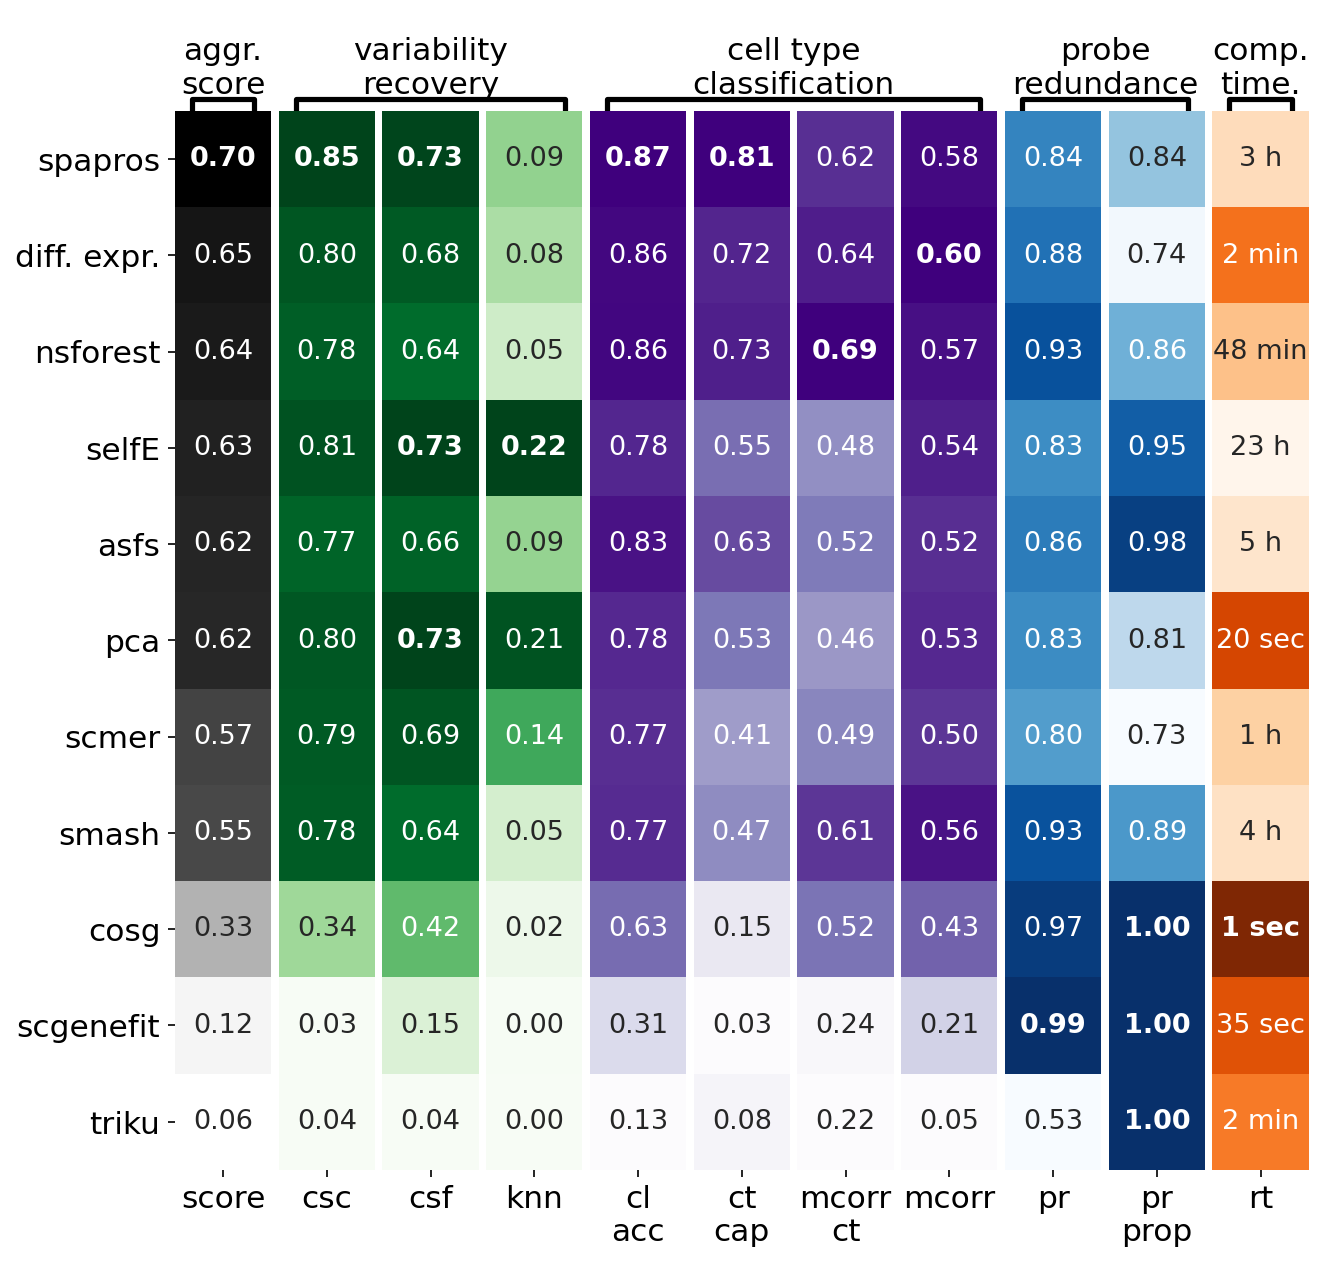

In [25]:
rename_cols = {
    'score'                               : "score",
    'cluster_similarity nmi_7_23'         : "csc",#"cluster sim. (coarse)",
    'cluster_similarity nmi_24_60'        : "csf",#"cluster sim. (fine)",
    'knn_overlap mean_overlap_AUC'        : "knn",#"knn overlap",
    'forest_clfs accuracy'                : "cl\nacc",#"classif. accuracy",
    'forest_clfs perct acc > 0.8'         : "ct\ncap",#"cell types captured",
    'gene_corr 1 - mean'                  : "pr",#"probe redundance",#"1 - mean corr",
    'gene_corr perct max < 0.8'           : "pr\nprop",#"proportion red. probes",
    'marker_corr per celltype'            : "mcorr\nct",#"cell type marker corr.",
    'marker_corr per marker mean > 0.025' : "mcorr",#"marker corr.",
    #"penalty low_expression"              : "lexpr",#"low expression",    
    #"penalty high_expression"             : "hexpr",#"high expression",
    'time_seconds'                        : "rt",#"run time",
}

summary_table(table_renamed[[col for col in rename_cols]], summaries="all", color_maps={"time_seconds":'Oranges_r'}, 
              rename_cols=rename_cols, rename_rows={}, time_format=["time_seconds"], 
              groups=[["aggr.\nscore",[0,0]],["variability\nrecovery",[1,3]],["cell type\nclassification",[4,7]],
                       ["probe\nredundance",[8,9]],["comp.\ntime.",[10,10]] #["techn.\nconstr.",[9,10]],
                     ], xticklabel_multialignment='center',
              log_scale=["time_seconds"], show=True, save=f"./figures/benchmark_{dataset}_n{n}.png")

# Mad, 150

In [26]:
n = 150
dataset = "Mad"

tables, selection_infos, selections_dict = get_data(dataset=dataset,n=n)
table_renamed = get_table(tables, selection_infos, selections_dict,n)

#for method in ["asfs","scmer"]:
#    table_renamed.loc[method] = np.nan
#    table_renamed.loc[method,"time_seconds"] = 172801

,cluster_similarity nmi_7_23,cluster_similarity nmi_24_60,knn_overlap mean_overlap_AUC,forest_clfs accuracy,forest_clfs perct acc > 0.8,gene_corr 1 - mean,gene_corr perct max < 0.8,marker_corr per marker,marker_corr per celltype,marker_corr per marker mean > 0.025,time_seconds,score
pca,0.874720,0.817547,0.396515,0.854181,0.746390,0.848449,0.859593,0.433320,0.693046,0.635654,10.447994,0.748273
diff. expr.,0.872554,0.757571,0.131638,0.889796,0.831795,0.883046,0.818902,0.545958,0.798691,0.685951,86.953962,0.724025
spapros,0.867433,0.817244,0.378635,0.889116,0.858398,0.855763,0.852828,0.485824,0.724032,0.636206,5310.544188,0.780764
nsforest,0.872231,0.742992,0.101615,0.894041,0.860323,0.926283,0.859775,0.531768,0.786922,0.649194,3085.367402,0.724731
scgenefit,0.429925,0.386256,0.020817,0.610303,0.208966,0.989725,0.998879,0.280172,0.401616,0.307587,49.651296,0.344317
smash,0.850035,0.734702,0.095609,0.893822,0.857243,0.939499,0.908189,0.548581,0.775484,0.637227,16591.869592,0.717824
scmer,0.872860,0.823706,0.399927,0.880021,0.808081,0.839443,0.846176,0.451960,0.722195,0.652783,6911.904893,0.771441
asfs,0.877013,0.798628,0.281871,0.884644,0.821127,0.888214,0.928306,0.494760,0.706103,0.621744,112519.939447,0.752695
triku,0.270729,0.241746,0.011393,0.400822,0.282823,0.798764,0.956944,0.254919,0.454094,0.214978,149.535010,0.258223
cosg,0.592842,0.471923,0.035842,0.736092,0.400019,0.978123,1.000000,0.387300,0.555445,0.470071,1.240908,0.467462


CAUTION: check if the averaging over values makes sense


,cluster_similarity nmi_7_23,cluster_similarity nmi_24_60,knn_overlap mean_overlap_AUC,forest_clfs accuracy,forest_clfs perct acc > 0.8,gene_corr 1 - mean,gene_corr perct max < 0.8,marker_corr per marker,marker_corr per celltype,marker_corr per marker mean > 0.025,time_seconds,score
spapros,0.867433,0.817244,0.378635,0.889116,0.858398,0.855763,0.852828,0.485824,0.724032,0.636206,5310.544188,0.780764
scmer,0.872860,0.823706,0.399927,0.880021,0.808081,0.839443,0.846176,0.451960,0.722195,0.652783,6911.904893,0.771441
asfs,0.877013,0.798628,0.281871,0.884644,0.821127,0.888214,0.928306,0.494760,0.706103,0.621744,112519.939447,0.752695
pca,0.874720,0.817547,0.396515,0.854181,0.746390,0.848449,0.859593,0.433320,0.693046,0.635654,10.447994,0.748273
nsforest,0.872231,0.742992,0.101615,0.894041,0.860323,0.926283,0.859775,0.531768,0.786922,0.649194,3085.367402,0.724731
diff. expr.,0.872554,0.757571,0.131638,0.889796,0.831795,0.883046,0.818902,0.545958,0.798691,0.685951,86.953962,0.724025
smash,0.850035,0.734702,0.095609,0.893822,0.857243,0.939499,0.908189,0.548581,0.775484,0.637227,16591.869592,0.717824
cosg,0.592842,0.471923,0.035842,0.736092,0.400019,0.978123,1.000000,0.387300,0.555445,0.470071,1.240908,0.467462
scgenefit,0.429925,0.386256,0.020817,0.610303,0.208966,0.989725,0.998879,0.280172,0.401616,0.307587,49.651296,0.344317
triku,0.270729,0.241746,0.011393,0.400822,0.282823,0.798764,0.956944,0.254919,0.454094,0.214978,149.535010,0.258223


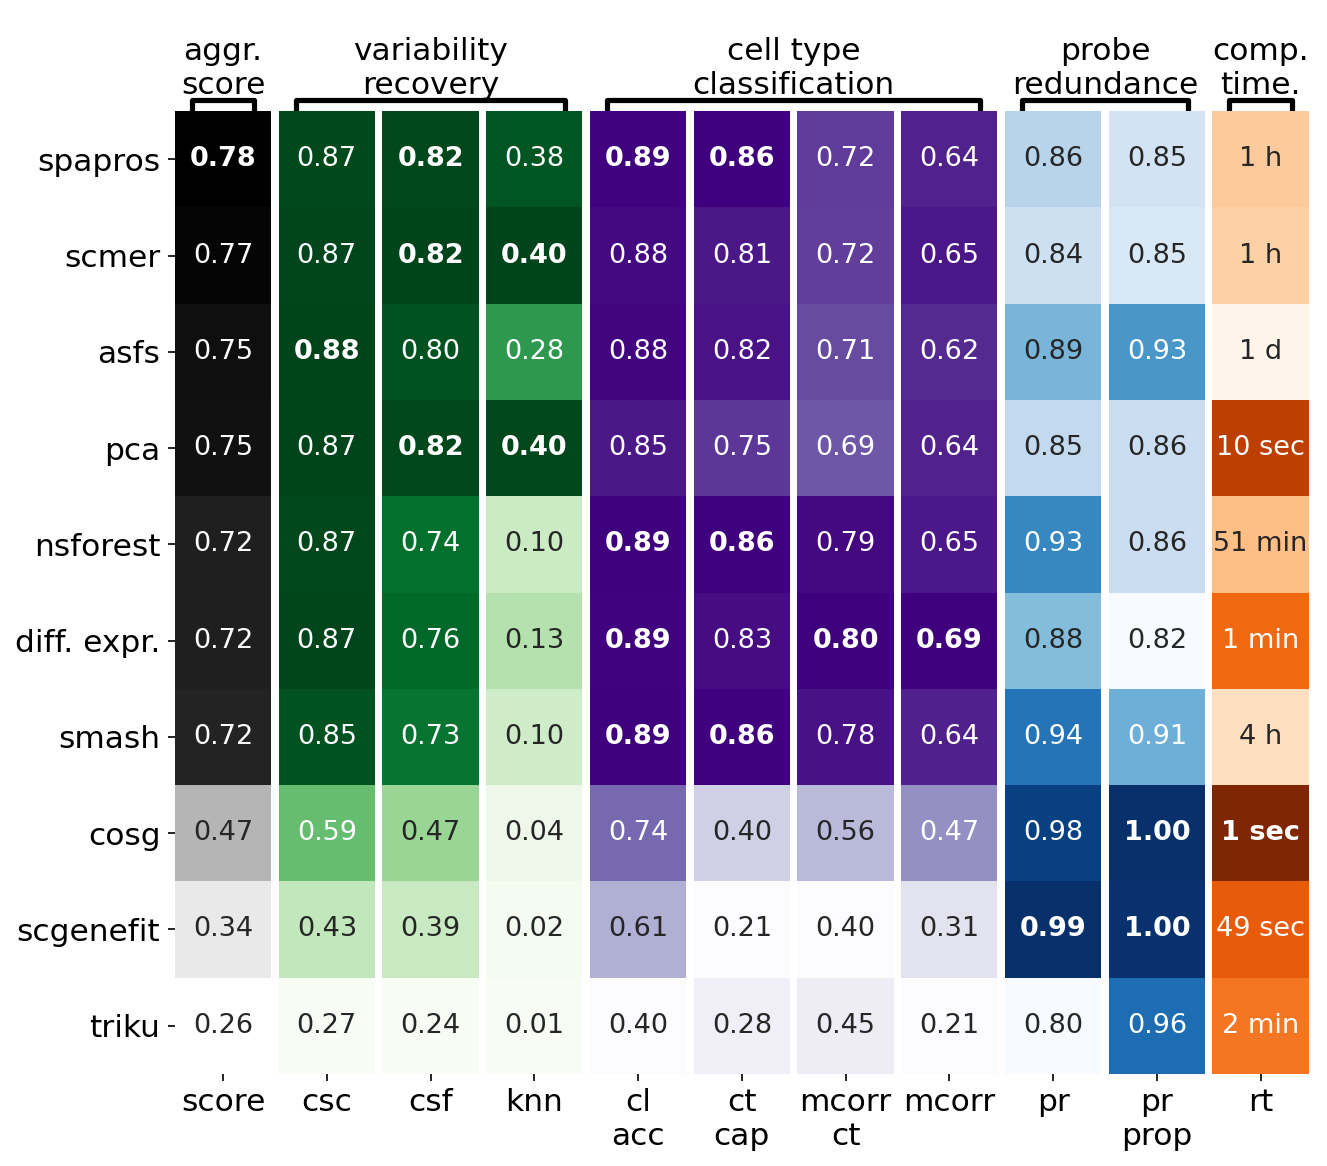

In [27]:
rename_cols = {
    'score'                               : "score",
    'cluster_similarity nmi_7_23'         : "csc",#"cluster sim. (coarse)",
    'cluster_similarity nmi_24_60'        : "csf",#"cluster sim. (fine)",
    'knn_overlap mean_overlap_AUC'        : "knn",#"knn overlap",
    'forest_clfs accuracy'                : "cl\nacc",#"classif. accuracy",
    'forest_clfs perct acc > 0.8'         : "ct\ncap",#"cell types captured",
    'gene_corr 1 - mean'                  : "pr",#"probe redundance",#"1 - mean corr",
    'gene_corr perct max < 0.8'           : "pr\nprop",#"proportion red. probes",
    'marker_corr per celltype'            : "mcorr\nct",#"cell type marker corr.",
    'marker_corr per marker mean > 0.025' : "mcorr",#"marker corr.",
    #"penalty low_expression"              : "lexpr",#"low expression",    
    #"penalty high_expression"             : "hexpr",#"high expression",
    'time_seconds'                        : "rt",#"run time",
}

summary_table(table_renamed[[col for col in rename_cols]], summaries="all", color_maps={"time_seconds":'Oranges_r'}, 
              rename_cols=rename_cols, rename_rows={}, time_format=["time_seconds"], 
              groups=[["aggr.\nscore",[0,0]],["variability\nrecovery",[1,3]],["cell type\nclassification",[4,7]],
                       ["probe\nredundance",[8,9]],["comp.\ntime.",[10,10]] #["techn.\nconstr.",[9,10]],
                     ], xticklabel_multialignment='center',
              log_scale=["time_seconds"], show=True, save=f"./figures/benchmark_{dataset}_n{n}.png")

# Lit, 50

In [28]:
n = 50
dataset = "Lit"

tables, selection_infos, selections_dict = get_data(dataset=dataset,n=n)
table_renamed = get_table(tables, selection_infos, selections_dict,n)

#for method in ["asfs","scmer"]:
#    table_renamed.loc[method] = np.nan
#    table_renamed.loc[method,"time_seconds"] = 172801

,cluster_similarity nmi_7_23,cluster_similarity nmi_24_60,knn_overlap mean_overlap_AUC,forest_clfs accuracy,forest_clfs perct acc > 0.8,gene_corr 1 - mean,gene_corr perct max < 0.8,time_seconds,score
pca,0.798867,0.690035,0.098295,0.522047,0.102890,0.841251,1.000000,13.419451,0.420767
diff. expr.,0.807024,0.660065,0.041617,0.519597,0.105803,0.868766,0.997451,163.528001,0.407801
spapros,0.802950,0.673841,0.068770,0.562552,0.117056,0.901423,0.976363,38881.745779,0.427496
spapros,0.803370,0.675458,0.068760,0.562552,0.117056,0.901423,0.976363,41011.760184,0.427834
nsforest,0.766914,0.637221,0.043103,0.529251,0.079145,0.925410,1.000000,6068.317156,0.393305
scgenefit,0.107942,0.260187,0.005051,0.205974,0.000000,0.986644,1.000000,35.667788,0.113690
smash,0.709939,0.595178,0.027133,0.498484,0.069319,0.944251,1.000000,43557.640972,0.363992
scmer,0.791563,0.674758,0.107028,0.495795,0.083902,0.762689,0.947954,4129.968371,0.407149
asfs,0.746472,0.615087,0.045045,0.482892,0.067278,0.904991,1.000000,14248.544889,0.371976
triku,0.293877,0.248779,0.006719,0.199566,0.028198,0.931795,0.997850,147.774680,0.148504


CAUTION: check if the averaging over values makes sense


,cluster_similarity nmi_7_23,cluster_similarity nmi_24_60,knn_overlap mean_overlap_AUC,forest_clfs accuracy,forest_clfs perct acc > 0.8,gene_corr 1 - mean,gene_corr perct max < 0.8,time_seconds,score
spapros,0.803160,0.674650,0.068765,0.562552,0.117056,0.901423,0.976363,39946.752982,0.427665
pca,0.798867,0.690035,0.098295,0.522047,0.102890,0.841251,1.000000,13.419451,0.420767
selfE,0.807579,0.682074,0.122888,0.508982,0.094373,0.839130,0.976363,79852.176243,0.419595
diff. expr.,0.807024,0.660065,0.041617,0.519597,0.105803,0.868766,0.997451,163.528001,0.407801
scmer,0.791563,0.674758,0.107028,0.495795,0.083902,0.762689,0.947954,4129.968371,0.407149
nsforest,0.766914,0.637221,0.043103,0.529251,0.079145,0.925410,1.000000,6068.317156,0.393305
asfs,0.746472,0.615087,0.045045,0.482892,0.067278,0.904991,1.000000,14248.544889,0.371976
smash,0.709939,0.595178,0.027133,0.498484,0.069319,0.944251,1.000000,43557.640972,0.363992
triku,0.293877,0.248779,0.006719,0.199566,0.028198,0.931795,0.997850,147.774680,0.148504
cosg,0.120495,0.336813,0.007743,0.283377,0.000000,0.969262,1.000000,1.272197,0.148353


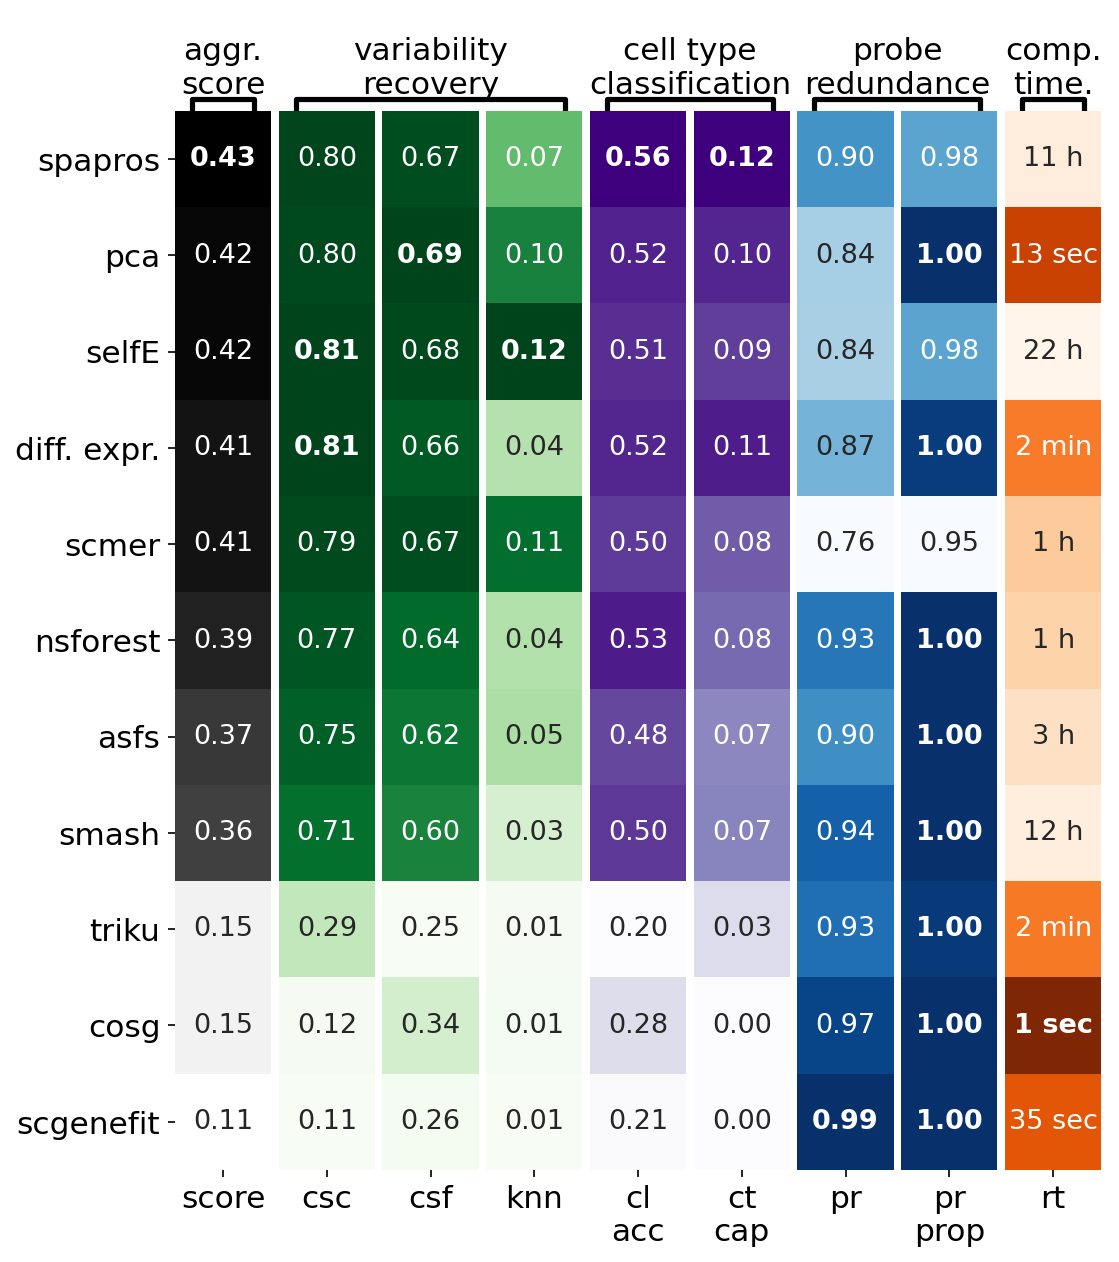

In [13]:
rename_cols = {
    'score'                               : "score",
    'cluster_similarity nmi_7_23'         : "csc",#"cluster sim. (coarse)",
    'cluster_similarity nmi_24_60'        : "csf",#"cluster sim. (fine)",
    'knn_overlap mean_overlap_AUC'        : "knn",#"knn overlap",
    'forest_clfs accuracy'                : "cl\nacc",#"classif. accuracy",
    'forest_clfs perct acc > 0.8'         : "ct\ncap",#"cell types captured",
    'gene_corr 1 - mean'                  : "pr",#"probe redundance",#"1 - mean corr",
    'gene_corr perct max < 0.8'           : "pr\nprop",#"proportion red. probes",
    #'marker_corr per celltype'            : "mcorr",#"marker corr.",
    #'marker_corr per marker mean > 0.025' : "mcorr\nct",#"cell type marker corr.",
    #"penalty low_expression"              : "lexpr",#"low expression",    
    #"penalty high_expression"             : "hexpr",#"high expression",
    'time_seconds'                        : "rt",#"run time",
}

summary_table(table_renamed[[col for col in rename_cols]], summaries="all", color_maps={"time_seconds":'Oranges_r'}, 
              rename_cols=rename_cols, rename_rows={}, time_format=["time_seconds"], 
              groups=[["aggr.\nscore",[0,0]],["variability\nrecovery",[1,3]],["cell type\nclassification",[4,5]],
                       ["probe\nredundance",[6,7]],["comp.\ntime.",[8,8]] #["techn.\nconstr.",[9,10]],
                     ], xticklabel_multialignment='center',
              log_scale=["time_seconds"], show=True, save=f"./figures/benchmark_{dataset}_n{n}.png")

# Lit, 150

In [14]:
n = 150
dataset = "Lit"

tables, selection_infos, selections_dict = get_data(dataset=dataset,n=n)
table_renamed = get_table(tables, selection_infos, selections_dict,n)

#for method in ["asfs","scmer"]:
#    table_renamed.loc[method] = np.nan
#    table_renamed.loc[method,"time_seconds"] = 172801

,cluster_similarity nmi_7_23,cluster_similarity nmi_24_60,knn_overlap mean_overlap_AUC,forest_clfs accuracy,forest_clfs perct acc > 0.8,gene_corr 1 - mean,gene_corr perct max < 0.8,time_seconds,score
pca,0.889277,0.801975,0.255558,0.605869,0.173027,0.864147,0.982731,18.918639,0.519192
diff. expr.,0.898281,0.767916,0.113132,0.602888,0.189323,0.882066,0.989046,164.815770,0.494608
spapros,0.883335,0.792603,0.237688,0.623603,0.178902,0.874529,0.992121,38168.910884,0.519564
spapros,0.884856,0.794304,0.237680,0.623603,0.178902,0.874529,0.992121,12485.539078,0.520100
nsforest,0.871541,0.757637,0.098299,0.622143,0.179296,0.918255,0.992612,6081.982071,0.488272
scgenefit,0.488443,0.403284,0.015953,0.374069,0.022553,0.989023,1.000000,34.167493,0.250435
smash,0.828932,0.709177,0.067835,0.615804,0.181431,0.938422,0.983355,42011.409126,0.466966
scmer,0.896049,0.799470,0.222740,0.607968,0.180786,0.841849,0.982120,5373.935230,0.516898
triku,0.386035,0.412341,0.015498,0.370925,0.057615,0.948237,0.999283,150.957280,0.242781
cosg,0.513682,0.420583,0.017854,0.406682,0.001446,0.981544,1.000000,1.298822,0.260718


CAUTION: check if the averaging over values makes sense


,cluster_similarity nmi_7_23,cluster_similarity nmi_24_60,knn_overlap mean_overlap_AUC,forest_clfs accuracy,forest_clfs perct acc > 0.8,gene_corr 1 - mean,gene_corr perct max < 0.8,time_seconds,score
spapros,0.884095,0.793454,0.237684,0.623603,0.178902,0.874529,0.992121,25327.224981,0.519832
pca,0.889277,0.801975,0.255558,0.605869,0.173027,0.864147,0.982731,18.918639,0.519192
scmer,0.896049,0.799470,0.222740,0.607968,0.180786,0.841849,0.982120,5373.935230,0.516898
diff. expr.,0.898281,0.767916,0.113132,0.602888,0.189323,0.882066,0.989046,164.815770,0.494608
nsforest,0.871541,0.757637,0.098299,0.622143,0.179296,0.918255,0.992612,6081.982071,0.488272
smash,0.828932,0.709177,0.067835,0.615804,0.181431,0.938422,0.983355,42011.409126,0.466966
cosg,0.513682,0.420583,0.017854,0.406682,0.001446,0.981544,1.000000,1.298822,0.260718
scgenefit,0.488443,0.403284,0.015953,0.374069,0.022553,0.989023,1.000000,34.167493,0.250435
triku,0.386035,0.412341,0.015498,0.370925,0.057615,0.948237,0.999283,150.957280,0.242781


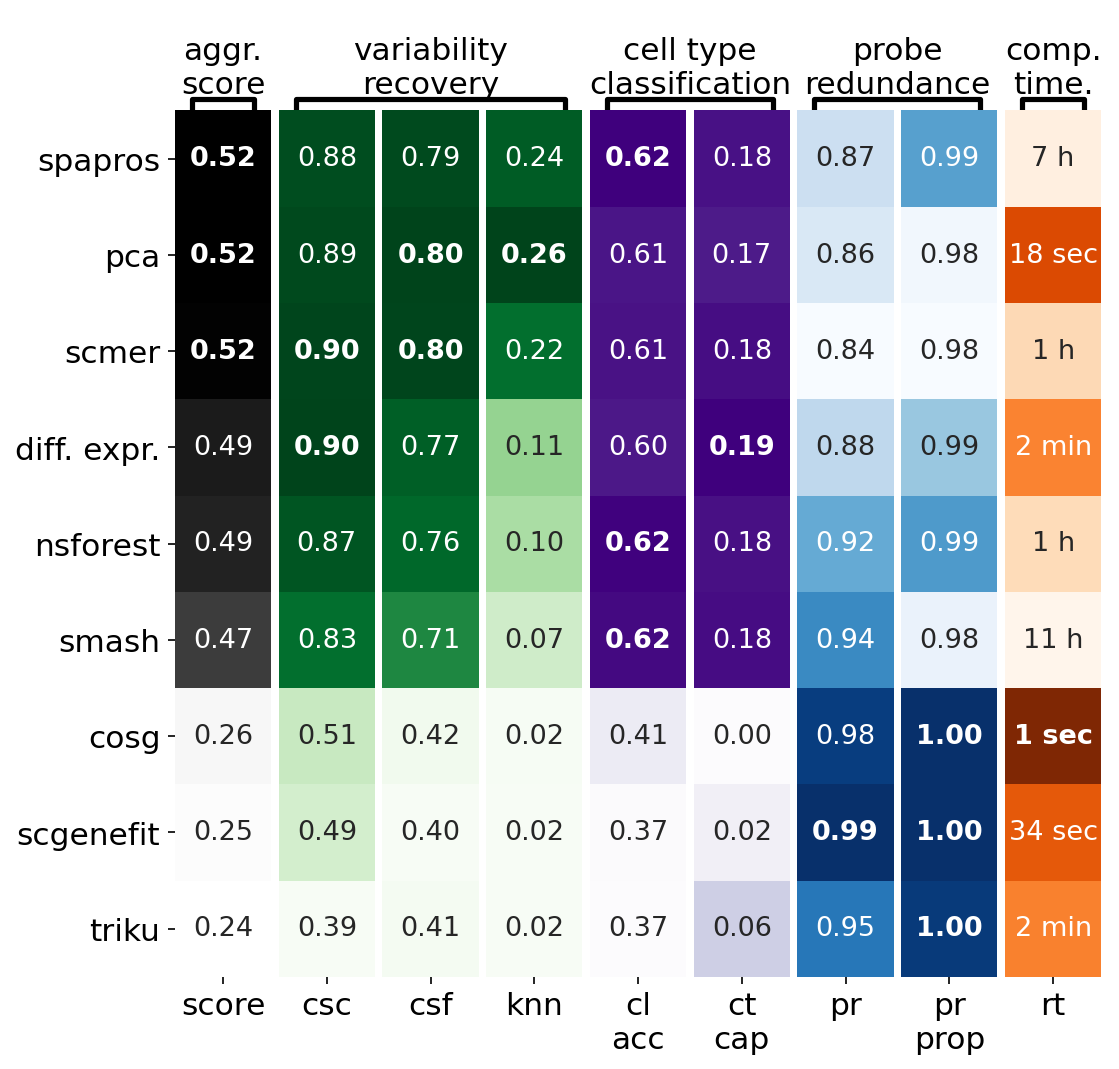

In [15]:
rename_cols = {
    'score'                               : "score",
    'cluster_similarity nmi_7_23'         : "csc",#"cluster sim. (coarse)",
    'cluster_similarity nmi_24_60'        : "csf",#"cluster sim. (fine)",
    'knn_overlap mean_overlap_AUC'        : "knn",#"knn overlap",
    'forest_clfs accuracy'                : "cl\nacc",#"classif. accuracy",
    'forest_clfs perct acc > 0.8'         : "ct\ncap",#"cell types captured",
    'gene_corr 1 - mean'                  : "pr",#"probe redundance",#"1 - mean corr",
    'gene_corr perct max < 0.8'           : "pr\nprop",#"proportion red. probes",
    #'marker_corr per celltype'            : "mcorr",#"marker corr.",
    #'marker_corr per marker mean > 0.025' : "mcorr\nct",#"cell type marker corr.",
    #"penalty low_expression"              : "lexpr",#"low expression",    
    #"penalty high_expression"             : "hexpr",#"high expression",
    'time_seconds'                        : "rt",#"run time",
}

summary_table(table_renamed[[col for col in rename_cols]], summaries="all", color_maps={"time_seconds":'Oranges_r'}, 
              rename_cols=rename_cols, rename_rows={}, time_format=["time_seconds"], 
              groups=[["aggr.\nscore",[0,0]],["variability\nrecovery",[1,3]],["cell type\nclassification",[4,5]],
                       ["probe\nredundance",[6,7]],["comp.\ntime.",[8,8]] #["techn.\nconstr.",[9,10]],
                     ], xticklabel_multialignment='center',
              log_scale=["time_seconds"], show=True, save=f"./figures/benchmark_{dataset}_n{n}.png")

### Fig S8b - comparison to Airway wall marker list

In [44]:
table = pd.read_csv("./scripts/results/Fig3g_evaluation/Meyer5loc_summary.csv",index_col=0)
table = table.rename({"Pascals_list":"Pascals"})
selection_info = pd.read_csv("./scripts/results/Fig3g_selection/selections_info.csv",index_col=0)
selections = pd.read_csv("./scripts/results/Fig3g_selection/selections.csv",index_col=0)

In [45]:
names_based_on_options = {
    "spapros" : {"method":"spapros"},
    "marker list" : {"method":"marker_list"},
}

# Get set_ids for each method name/configuration
name_to_selections = {}
for name, options in names_based_on_options.items():
    filt = True
    for o, val in options.items():
        filt = filt & (selection_info[o] == val)
    name_to_selections[name] = [s for s in selection_info.loc[filt].index.tolist() if s in table.index]
    
# Convert set_ids to names and take mean if method occured multiple times (applies for method "random" only here)
table_renamed = pd.DataFrame(columns=table.columns)
for name, selections in name_to_selections.items():
    if len(selections) == 1:
        table_renamed.loc[name] = table.loc[selections[0]]
    else:
        table_renamed.loc[name] = table.loc[selections].mean()
        
# Aggregate score
aggregate_var_recov = ['cluster_similarity nmi_7_23', 'cluster_similarity nmi_24_60','knn_overlap mean_overlap_AUC'] 
aggregate_ct_clf = ['forest_clfs accuracy', 'forest_clfs perct acc > 0.8']
tmp1 = table_renamed[aggregate_var_recov].mean(axis=1)
tmp2 = table_renamed[aggregate_ct_clf].mean(axis=1)
table_renamed["score"] = pd.concat([tmp1,tmp2],axis=1).mean(axis=1)
table_renamed = table_renamed.sort_values("score",ascending=False)

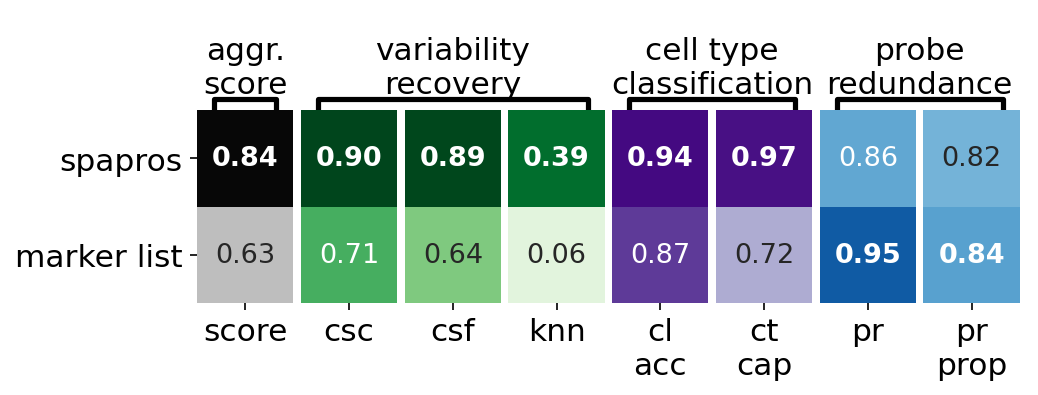

In [49]:
#rename_cols = {
#    'cluster_similarity nmi_7_23'         : "cluster sim. (coarse)",
#    'cluster_similarity nmi_24_60'        : "cluster sim. (fine)",
#    'knn_overlap mean_overlap_AUC'        : "knn overlap",
#    'forest_clfs accuracy'                : "classif. accuracy",
#    'forest_clfs perct acc > 0.8'         : "cell types captured",
#    'gene_corr 1 - mean'                  : "probe redundance",#"1 - mean corr",
#    'gene_corr perct max < 0.8'           : "proportion red. probes",
#    #'marker_corr per celltype'            : "cell type marker corr.",
#    #'marker_corr per marker mean > 0.025' : "marker corr.",
#    #"penalty low_expression"              : "low expression",    
#    #"penalty high_expression"             : "high expression",
#    #'time_seconds'                        : "run time",
#}

rename_cols = {
    'score'                               : "score",
    'cluster_similarity nmi_7_23'         : "csc",#"cluster sim. (coarse)",
    'cluster_similarity nmi_24_60'        : "csf",#"cluster sim. (fine)",
    'knn_overlap mean_overlap_AUC'        : "knn",#"knn overlap",
    'forest_clfs accuracy'                : "cl\nacc",#"classif. accuracy",
    'forest_clfs perct acc > 0.8'         : "ct\ncap",#"cell types captured",
    'gene_corr 1 - mean'                  : "pr",#"probe redundance",#"1 - mean corr",
    'gene_corr perct max < 0.8'           : "pr\nprop",#"proportion red. probes",
    #'marker_corr per celltype'            : "mcorr",#"marker corr.",
    #'marker_corr per marker mean > 0.025' : "mcorr\nct",#"cell type marker corr.",
    #"penalty low_expression"              : "lexpr",#"low expression",    
    #"penalty high_expression"             : "hexpr",#"high expression",
    #'time_seconds'                        : "rt",#"run time",
}


cmap_lim = {
    'score'                               : [0.5,0.85],
    'cluster_similarity nmi_7_23'         : [0.4,0.9],
    'cluster_similarity nmi_24_60'        : [0.4,0.9],
    'knn_overlap mean_overlap_AUC'        : [0.0,0.45],
    'forest_clfs accuracy'                : [0.5,0.95],
    'forest_clfs perct acc > 0.8'         : [0.5,1.0],
    'gene_corr 1 - mean'                  : [0.7,1.0],
    'gene_corr perct max < 0.8'           : [0.7,0.95],
    #'marker_corr per celltype'            : [0.5,1.0],
    #'marker_corr per marker mean > 0.025' : [0.5,1.0],
}

summary_table(table_renamed[[col for col in rename_cols]], summaries="all", #color_maps={"time_seconds":'Oranges_r'}, 
              rename_cols=rename_cols, rename_rows={}, #time_format=["time_seconds"], 
              groups=[["aggr.\nscore",[0,0]],["variability\nrecovery",[1,3]],["cell type\nclassification",[4,5]],
                       ["probe\nredundance",[6,7]]#,["comp.\ntime.",[9,9]] #["techn.\nconstr.",[9,10]],
                     ],
              color_limits=cmap_lim, xticklabel_multialignment='center',
              #log_scale=["time_seconds"], 
              show=True, save="./figures/Fig3g_comparison_to_marker_list.png")

### Fig S8c - comparison to ISS panel on dev heart data

In [19]:
table = pd.read_csv("./scripts/results/FigAsp_evaluation/Asp_summary.csv",index_col=0)

table_renamed = table.rename(index={'selection_0':'spapros', 'selection_ISS':'ISS panel'})

# Aggregate score
aggregate_var_recov = ['cluster_similarity nmi_7_23', 'cluster_similarity nmi_24_60','knn_overlap mean_overlap_AUC'] 
aggregate_ct_clf = ['forest_clfs accuracy', 'forest_clfs perct acc > 0.8']
tmp1 = table_renamed[aggregate_var_recov].mean(axis=1)
tmp2 = table_renamed[aggregate_ct_clf].mean(axis=1)
table_renamed["score"] = pd.concat([tmp1,tmp2],axis=1).mean(axis=1)
table_renamed = table_renamed.sort_values("score",ascending=False)

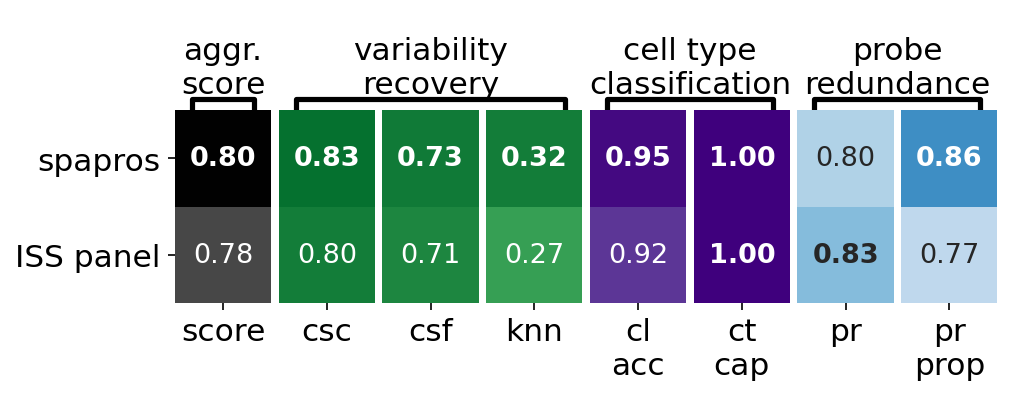

In [20]:
rename_cols = {
    'score'                               : "score",
    'cluster_similarity nmi_7_23'         : "csc",#"cluster sim. (coarse)",
    'cluster_similarity nmi_24_60'        : "csf",#"cluster sim. (fine)",
    'knn_overlap mean_overlap_AUC'        : "knn",#"knn overlap",
    'forest_clfs accuracy'                : "cl\nacc",#"classif. accuracy",
    'forest_clfs perct acc > 0.8'         : "ct\ncap",#"cell types captured",
    'gene_corr 1 - mean'                  : "pr",#"probe redundance",#"1 - mean corr",
    'gene_corr perct max < 0.8'           : "pr\nprop",#"proportion red. probes",
}


cmap_lim = {
    'score'                               : [0.7,0.8],
    'cluster_similarity nmi_7_23'         : [0.4,0.9],
    'cluster_similarity nmi_24_60'        : [0.4,0.8],
    'knn_overlap mean_overlap_AUC'        : [0.0,0.40],
    'forest_clfs accuracy'                : [0.8,0.95],
    'forest_clfs perct acc > 0.8'         : [0.5,1.0],
    'gene_corr 1 - mean'                  : [0.7,1.0],
    'gene_corr perct max < 0.8'           : [0.7,0.95],
    #'marker_corr per celltype'            : [0.5,1.0],
    #'marker_corr per marker mean > 0.025' : [0.5,1.0],
}

summary_table(table_renamed[[col for col in rename_cols]], summaries="all", #color_maps={"time_seconds":'Oranges_r'}, 
              rename_cols=rename_cols, rename_rows={}, #time_format=["time_seconds"], 
              groups=[["aggr.\nscore",[0,0]],["variability\nrecovery",[1,3]],["cell type\nclassification",[4,5]],
                       ["probe\nredundance",[6,7]]#,["comp.\ntime.",[9,9]] #["techn.\nconstr.",[9,10]],
                     ],
              color_limits=cmap_lim, xticklabel_multialignment='center',
              #log_scale=["time_seconds"], 
              show=True, save="./figures/Fig3h_comparison_to_ISS_panel_sc.png")

#### ST dataset

In [21]:
table = pd.read_csv("./scripts/results/FigAsp_evaluation_ST/Asp_ST_summary.csv",index_col=0)

table_renamed = table.rename(index={'selection_0':'spapros', 'selection_ISS':'ISS panel'})

# Aggregate score
aggregate_var_recov = ['cluster_similarity nmi_7_23', 'cluster_similarity nmi_24_60','knn_overlap mean_overlap_AUC'] 
aggregate_ct_clf = ['forest_clfs accuracy', 'forest_clfs perct acc > 0.8']
tmp1 = table_renamed[aggregate_var_recov].mean(axis=1)
tmp2 = table_renamed[aggregate_ct_clf].mean(axis=1)
table_renamed["score"] = pd.concat([tmp1,tmp2],axis=1).mean(axis=1)
table_renamed = table_renamed.sort_values("score",ascending=False)

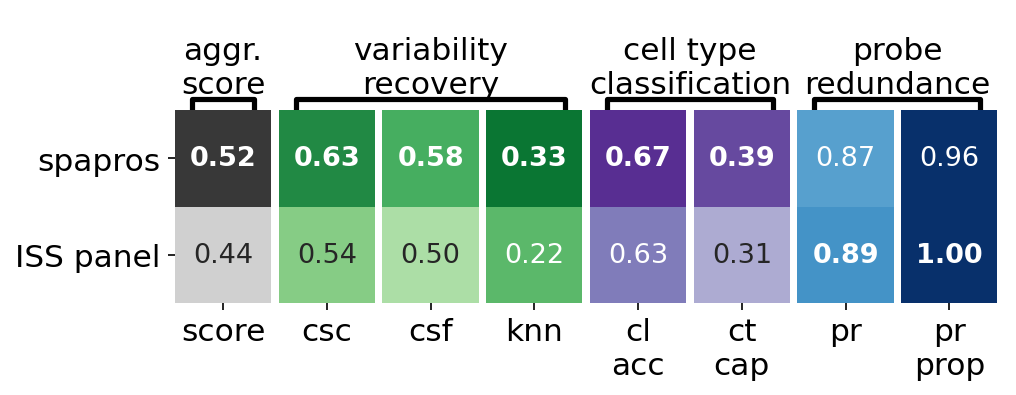

In [22]:
rename_cols = {
    'score'                               : "score",
    'cluster_similarity nmi_7_23'         : "csc",#"cluster sim. (coarse)",
    'cluster_similarity nmi_24_60'        : "csf",#"cluster sim. (fine)",
    'knn_overlap mean_overlap_AUC'        : "knn",#"knn overlap",
    'forest_clfs accuracy'                : "cl\nacc",#"classif. accuracy",
    'forest_clfs perct acc > 0.8'         : "ct\ncap",#"cell types captured",
    'gene_corr 1 - mean'                  : "pr",#"probe redundance",#"1 - mean corr",
    'gene_corr perct max < 0.8'           : "pr\nprop",#"proportion red. probes",
}


cmap_lim = {
    'score'                               : [0.4,0.55],
    'cluster_similarity nmi_7_23'         : [0.4,0.7],
    'cluster_similarity nmi_24_60'        : [0.4,0.7],
    'knn_overlap mean_overlap_AUC'        : [0.0,0.40],
    'forest_clfs accuracy'                : [0.5,0.7],
    'forest_clfs perct acc > 0.8'         : [0.2,0.45],
    'gene_corr 1 - mean'                  : [0.7,1.0],
    'gene_corr perct max < 0.8'           : [0.7,0.95],
    #'marker_corr per celltype'            : [0.5,1.0],
    #'marker_corr per marker mean > 0.025' : [0.5,1.0],
}

summary_table(table_renamed[[col for col in rename_cols]], summaries="all", #color_maps={"time_seconds":'Oranges_r'}, 
              rename_cols=rename_cols, rename_rows={}, #time_format=["time_seconds"], 
              groups=[["aggr.\nscore",[0,0]],["variability\nrecovery",[1,3]],["cell type\nclassification",[4,5]],
                       ["probe\nredundance",[6,7]]#,["comp.\ntime.",[9,9]] #["techn.\nconstr.",[9,10]],
                     ],
              color_limits=cmap_lim, xticklabel_multialignment='center',
              #log_scale=["time_seconds"], 
              show=True, save="./figures/Fig3h_comparison_to_ISS_panel_ST.png")